# EDA


Putting it all together, the `get_playlist_tracks` function retrieves basic details for each song in a specified Spotify playlist using its URI. The `playlist_features` function then iterates through these tracks using their IDs to extract additional information, such as danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and more. From there, we create a Pandas dataframe by passing in the extracted information.

In [1]:
import pandas as pd
from IPython.core.display import HTML
from IPython.display import set_matplotlib_formats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
from functools import partial
from rpy2.ipython import html
from rpy2.robjects.packages import importr
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
import warnings # Hide warnings if there are any
warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
# initiate notebook for offline plot
init_notebook_mode(connected=True)


# Import Data
all_tracks = pd.read_csv("../assets/data/all_tracks.csv", index_col=False)
all_tracks_with_lyrics = pd.read_csv("../assets/data/all_tracks+lyrics.csv", index_col=False)

C:\Python311\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [2]:
## Set Default Plot Chart Style Configurations
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (8, 5) # Set default figure size.
plt.rc('font', family='Roboto') # Set default font family

pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})

%load_ext rpy2.ipython 
%R require(ggplot2)
%R require(hrbrthemes)
%R require(patchwork)
%R require(ragg)
%R require(plotly)
%R require(ggiraph)
%R require(IRkernel)
%R require(IRdisplay)

Loading required package: ggplot2
In addition: Warning message:
package 'ggplot2' was built under R version 4.1.3 


Loading required package: hrbrthemes
Registering Windows fonts with R
NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.
      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and
      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow
In addition: Warning message:
package 'hrbrthemes' was built under R version 4.1.3 


Loading required package: patchwork


Loading required package: ragg
In addition: Warning message:
package 'ragg' was built under R version 4.1.3 


Loading required package: plotly

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout



Loading required package: ggiraph
In addition: Warning message:
package 'ggiraph' was built under R version 4.1.3 


Loading required package: IRkernel


Loading required package: IRdisplay
In addition: Warning message:
package 'IRdisplay' was built under R version 4.1.3 


In [3]:
%%R
css_default_hover <- girafe_css_bicolor(primary = "yellow", secondary = "red")

set_girafe_defaults(
  opts_hover = opts_hover(css = "fill:#8c8c8c;fill:#E9FC88;stroke:black;stroke-width:0.25px;"),
  opts_tooltip = opts_tooltip(css = "padding:4px;background-color:#333333;color:white;font-family:Roboto Condensed;background-color:#d8118c;border-radius:3px;"),
  opts_sizing = opts_sizing(rescale = TRUE)
)

In [4]:
all_tracks = all_tracks[['name', 'track_id', 'album', 'artist', 'artist_id', 'release_date',
       'length', 'popularity', 'artist_pop', 'artist_genres',
       'artist_followers', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
       'liveness', 'loudness', 'loudness_scaled', 'speechiness', 'tempo',
       'valence', 'key', 'mode', 'time_signature', 'playlist']]

all_tracks[['name',  'artist', 'popularity', 'artist_pop','artist_genres',
       'acousticness', 'danceability', 'energy', 'instrumentalness', 
       'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key', 'time_signature','length','release_date']].head(4)


name        artist  popularity  artist_pop  \
0            Beautiful Things  Benson Boone         100          86   
1                     OKLOSER      Doja Cat          69          87   
2  i like the way you kiss me       Artemas          95          81   
3                   Too Sweet        Hozier          88          86   

                                              artist_genres  acousticness  \
0                                 ['singer-songwriter pop']      0.151000   
1                                      ['dance pop', 'pop']      0.025500   
2                                                        []      0.000938   
3  ['irish singer-songwriter', 'modern rock', 'pov: indie']      0.029500   

   danceability  energy  instrumentalness  liveness  loudness  speechiness  \
0         0.472   0.471          0.000000    0.1400    -5.692       0.0603   
1         0.898   0.674          0.000000    0.0835    -8.373       0.3030   
2         0.599   0.946          0.010600    0.0826    -4.263       0.0447   
3         0.741   0.620          0.000809    0.0398    -5.505       0.0412   

     tempo  valence  key  time_signature  length release_date  
0  105.029    0.219   10               3  180304   2024-01-18  
1  152.046    0.883    1               4  169066   2024-04-05  
2  151.647    0.747   11               4  142514   2024-03-19  
3  117.038    0.934   10               4  251424   2024-03-22



## Visualizing the Data

Our next step involves visually representing the distribution of different track features, such as song popularity. To achieve this, we use the powerful `matplotlib` and `seaborn` libraries. 

### Top Artist Genres


The following code generates a dictionary that contains the frequency of artist genres, which is then converted into a dataframe sorted by tallying the number of occurrences of each genre The resulting dataframe exhibits the genres and the number of times they occur.


In [5]:
genres_dict = {}
for x in all_tracks.artist_genres:
    # Converting string to list
    res = x.replace("'", "").strip('][').split(', ')
    for genre_i in res:
        if genre_i == "":
            break
        if genre_i in genres_dict:
            genres_dict[genre_i] += 1
        else:
            genres_dict[genre_i] = 1

# Convert Dictionary to Dataframe
df_genres = pd.DataFrame(genres_dict.items(), columns=['Genre', 'Freq']).sort_values('Freq', ascending=False)
df_genres = df_genres.reset_index(drop = True)

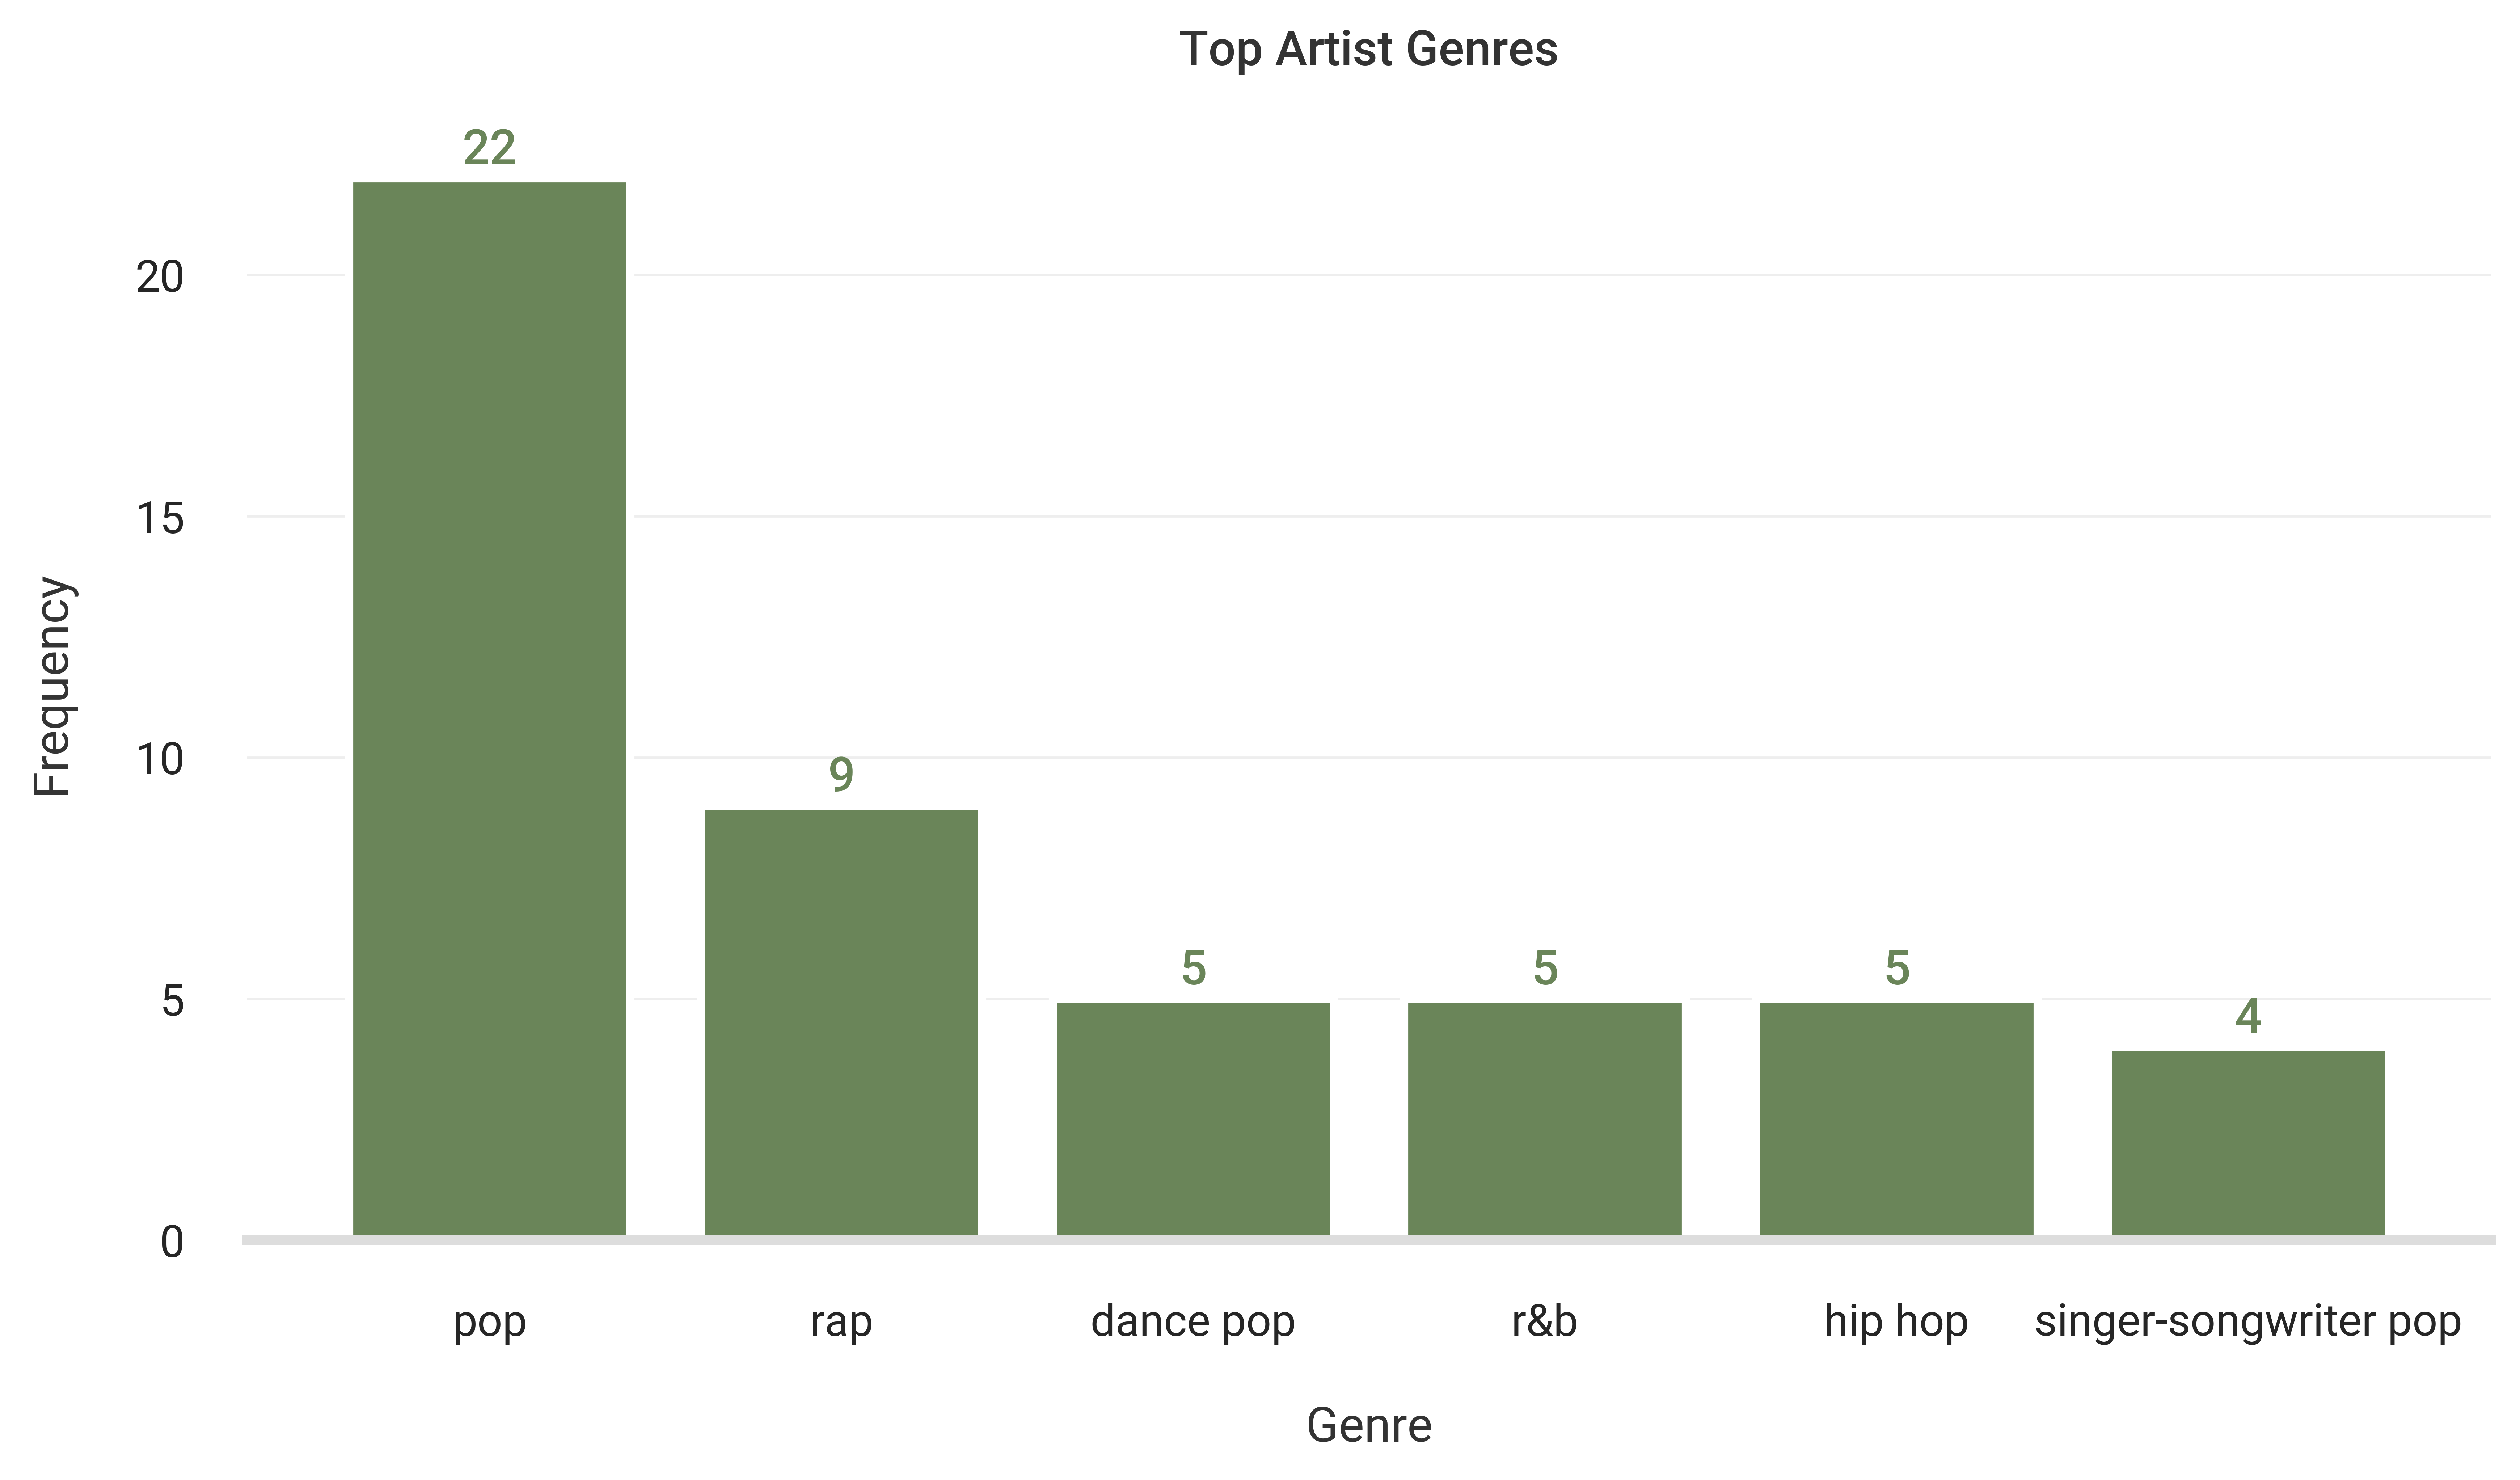

In [6]:
fig, ax = plt.subplots(figsize = (10,5), dpi =400)

# Save the chart so we can loop through the bars below.
bars = ax.bar(x=df_genres.head(6)['Genre'], height=df_genres.head(6)['Freq'],color="#6A8559")

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('Genre', labelpad=15, color='#333333')
ax.set_ylabel('Frequency', labelpad=15, color='#333333')
ax.set_title('Top Artist Genres', pad=15, color='#333333',
             weight='bold')

#fig.tight_layout()
plt.savefig("../assets/images/artist_genres.png", format="png", dpi=1200)

### Artist Features

Next, we visualize data for each artist from the playlist track data.

In [7]:
# Count distinct values in column
tallyArtists = all_tracks.value_counts(["artist", "artist_id"]).reset_index(name='counts')
topArtist = tallyArtists['artist_id'][1]

tallyArtistPop = all_tracks.value_counts(["artist_pop"]).reset_index(name='counts')
tallyPop = all_tracks.value_counts(["popularity"]).reset_index(name='counts')
tallyPop = tallyPop[tallyPop['popularity'] > 0]

In [8]:
%%R -i tallyPop -i tallyArtistPop -i tallyArtists -i df_genres

pop_plot <- ggplot(data = tallyPop, mapping = aes(x = popularity, y = counts, tooltip = popularity, data_id = popularity)) +
  geom_smooth(alpha=0.95, fill="#eeeeee", color="#ff99b1") +
  geom_bar_interactive(stat="identity", fill="#eeeeee", alpha=0.75, color = "#a9a9a9",size=0.5) +
  geom_col(fill="#eeeeee", alpha = 0.9, color = "#a9a9a9") + 
  theme_ipsum_rc(axis_text_size = 8, plot_margin = ggplot2::margin(t = 0,l = 0,b = 10,r = 10),plot_title_size = 8) + 
  ylab("# of songs") + xlab("track popularity") + ggtitle('Figure 1. Track Popularity Distribution')

artists_pop_plot <- ggplot(data = tallyArtistPop, mapping = aes(x = artist_pop, y = counts, tooltip = artist_pop, data_id = artist_pop)) +
  geom_bar_interactive(stat="identity", alpha=0.95,fill="#eeeeee",color="#a9a9a9",size=0.5) +
  geom_col(fill="#f59b23", alpha = 0.9, color = "#030404") + 
  geom_smooth(alpha=0.5, color="#030404", fill="#f59b23") + 
  ylab("# of artists") + xlab("artist popularity") + ggtitle('Figure 2. Artist Popularity Distribution') +
  theme_ipsum_rc(axis_text_size = 8, plot_margin = ggplot2::margin(t = 0,l = 10,b = 10,r = 2),plot_title_size = 8)

genres_plot <- ggplot(data = df_genres %>% head(12), mapping = aes(y = reorder(Genre,Freq), x = Freq, tooltip = Genre, data_id = Genre)) +
  geom_bar_interactive(stat="identity", fill="#fc65a2",color = "#030404",size=0.25) +
  #geom_col(fill="#fc65a2", alpha = 0.9, color = "#030404") + 
  theme_ipsum_rc(axis_text_size = 8,plot_margin = ggplot2::margin(t=2,r=-25,0,0),plot_title_size = 11) + 
  ylab(NULL) + xlab("# of songs") + ggtitle('Figure 3. Artist Genre Distribution (Top 12)')


p3 <- (pop_plot | artists_pop_plot) / genres_plot
p2 <- girafe(code = print(p3)) 

p2$sizingPolicy$padding <- 10
#htmlwidgets::saveWidget(object2save, file = "example.html", selfcontained = FALSE, libdir = "lib")

htmlwidgets::saveWidget(p2, "./genres_plot.html")

#ragg::agg_png(filename = "../assets/images/mypatchwork1.png", width = 9285, height = 5695, units = "px", res = 900)
#(pop_plot | artists_pop_plot) / genres_plot
#invisible(dev.off())
#knitr::include_graphics("../assets/images/mypatchwork1.png")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation:
tooltip, data_id
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation:
tooltip, data_id
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 


In [9]:
from IPython.core.display import display, HTML
from IPython.display import IFrame
IFrame(src='./genres_plot.html', width="100%", height="100%")

In [10]:
%%R 
# Create barplot
genres_plot <- ggplot(data = df_genres %>% head(12), mapping = aes(y = reorder(Genre,Freq), x = Freq, tooltip = Genre, data_id = Genre)) +
  geom_col(fill="#fc65a2", alpha = 0.99, color = "#030404", size=0.35,
  aes(text = paste0("<b>", "Genre: ", Genre, "</b>", "<br>", "<b>Freq: </b>", Freq))) + 
  coord_cartesian(xlim = c(0.75, NA)) +
  theme_ipsum_rc(axis_text_size = 8,plot_margin = ggplot2::margin(t=20,r=20,b=5,l=0),plot_title_size = 13) + 
  ylab(NULL) + xlab(NULL) #+ ggtitle('Figure 1. Track & Artist Popularity Distribution')

fig3 <- ggplotly(genres_plot, tooltip = "text")%>% 
  layout(hoverlabel=list(bgcolor = "#ffffff")) %>%  
  layout(annotations = list( 
    list(x = 0.012 , y = 1.05, text = '<b>Figure 2.</b> Artist Genre Distribution (Top 12)', showarrow = F, xref='paper', yref='paper')) 
  ) 

pop_plot <- ggplot(data = tallyPop, mapping = aes(x = popularity, y = counts, tooltip = popularity)) +
  geom_col(fill="#eeeeee", alpha = 1, color = "#a9a9a9",size=0.25) + 
  geom_smooth(alpha=0.45, fill="#eeeeee", span=0.5, color="transparent") +
  geom_smooth(color="#ff99b1",se=FALSE, span=0.5, alpha=1) + 
  coord_cartesian(ylim = c(0, NA)) + ylab("# of songs") + xlab("track popularity") +
  theme_ipsum_rc(axis_text_size = 8, plot_margin = ggplot2::margin(t = 0,l = 0,b = 0,r = 10),plot_title_size = 8)

artists_pop_plot <- ggplot(data = tallyArtistPop, mapping = aes(x = artist_pop, y = counts, tooltip = artist_pop, data_id = artist_pop)) +
  geom_col(fill="#f59b23", alpha = 0.9, color = "#030404",size=0.25) + 
  geom_smooth(alpha=0.45, fill="#f59b23", span=0.65, color="transparent") +
  geom_smooth(color="#030404",se=FALSE, span=0.65, alpha=1) +
  coord_cartesian(ylim = c(0, NA)) + ylab("# of artists") + xlab("artist popularity") + 
  theme_ipsum_rc(axis_text_size = 8, plot_margin = ggplot2::margin(t = 0,l = 10,b = 0,r = 2),plot_title_size = 8)


fig1 <- ggplotly(pop_plot) #%>% layout(annotations = list(x = 0.01 , y = 1.105, text = '<b>Figure 1.</b> Track Popularity Distribution', showarrow = F, xref='paper', yref='paper'))
fig2 <- ggplotly(artists_pop_plot) 

x1 <- subplot(fig1, fig2, margin=0.085, titleY = TRUE, titleX = TRUE) %>%
  layout(annotations = list(list(x = 0.01 , y = 1.2, text = '<b>Figure 1.</b> Track & Artist Popularity Distribution', showarrow = F, xref='paper', yref='paper'))
    #list(x = 0.5 , y = 1.2, text = '<b>Figure 2.</b> Artist Popularity Distribution', showarrow = F, xref='paper', yref='paper')) 
  )

fig <- subplot(x1, fig3, nrows = 2, heights = c(0.4, 0.6), titleY = TRUE, titleX = TRUE, margin = 0.092)
#%>% layout(template='plotly_white')


htmlwidgets::saveWidget(fig, "genres_plot2.html")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


In addition: There were 12 warnings (use warnings() to see them)


![](../assets/images/mypatchwork1.png)

### Track Features

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Initialize figure with subplots
fig = make_subplots(
    rows=3, cols=3,
    column_widths=[0.33, 0.33, 0.33], row_heights=[0.5, 0.5,0.5],
    vertical_spacing=0.165,
    specs=[[{"type": "histogram"}, {"type": "histogram"},{"type": "histogram"}],
           [{"type": "bar"}, {"type": "bar"},{"type": "histogram"}],
           [{"type": "bar"}, {"type": "bar"},{"type": "histogram"}]],
            #subplot_titles=('Sin(x)', 'Subplot title2', 'Subplot title2',"")
            )

# COLUMN 1 ----------------------------------------------
fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["acousticness"], marker=dict(color="#F3E176"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=1, size=0.12)), row=1, col=1)
fig.update_xaxes(title_text="acousticness", row=1, col=1)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["liveness"], marker=dict(color="#F3E176"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=0.6, size=0.0225)), row=2, col=1)
fig.update_xaxes(title_text="liveness", row=2, col=1)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["tempo"], marker=dict(color="#F3E176"), showlegend=False,
                           nbinsx=10, xbins=dict(start=80, end=200, size=12)), row=3, col=1)
fig.update_xaxes(title_text="tempo", row=3, col=1)

fig.update_traces(marker_line_color='#E1C214') #marker_color='rgb(158,202,225)')



# COLUMN 2 ----------------------------------------------
fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["danceability"], marker=dict(color="#F9C762"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=1, size=0.0295)), row=1, col=2)
fig.update_xaxes(title_text="danceability", row=1, col=2)
fig.update_traces(marker_line_color='#ECA009', row=1, col=2)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["loudness_scaled"], marker=dict(color="#F9C762"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=2, size=0.1085)), row=2, col=2)
fig.update_xaxes(title_text="loudness_scaled", row=2, col=2)
fig.update_traces(marker_line_color='#ECA009', row=2, col=2)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["valence"], marker=dict(color="#F9C762"), showlegend=False,
                           nbinsx=12, xbins=dict(start=0, end=1, size=0.1)), row=3, col=2)
fig.update_xaxes(title_text="valence", row=3, col=2)
fig.update_traces(marker_line_color='#ECA009', row=3, col=2)



# COLUMN 3 ----------------------------------------------

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["energy"], marker=dict(color="#FCB484"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=1, size=0.1)), row=1, col=3)
fig.update_xaxes(title_text="energy", row=1, col=3)
fig.update_traces(marker_line_color='#EF6306', row=1, col=3)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["speechiness"], marker=dict(color="#FCB484"), showlegend=False,
                           nbinsx=10, xbins=dict(start=0, end=0.6, size=0.022)), row=2, col=3)
fig.update_xaxes(title_text="speechiness", row=2, col=3)
fig.update_traces(marker_line_color='#EF6306', row=2, col=3)

fig.add_trace(go.Histogram(histfunc="count", x=all_tracks["key"], marker=dict(color="#FCB484"), showlegend=False,
                           nbinsx=12, xbins=dict(start=0, end=12, size=1)), row=3, col=3)
fig.update_xaxes(title_text="key", row=3, col=3)
fig.update_traces(marker_line_color='#EF6306', row=3, col=3)




# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_white",
    font_family = "Roboto",
    margin=dict(r=10, t=25, b=25, l=60),
    bargap=0.1)

fig.update_traces(marker_line_width=1.5, opacity=0.96)
fig.write_html("track_features.html")
fig.show()

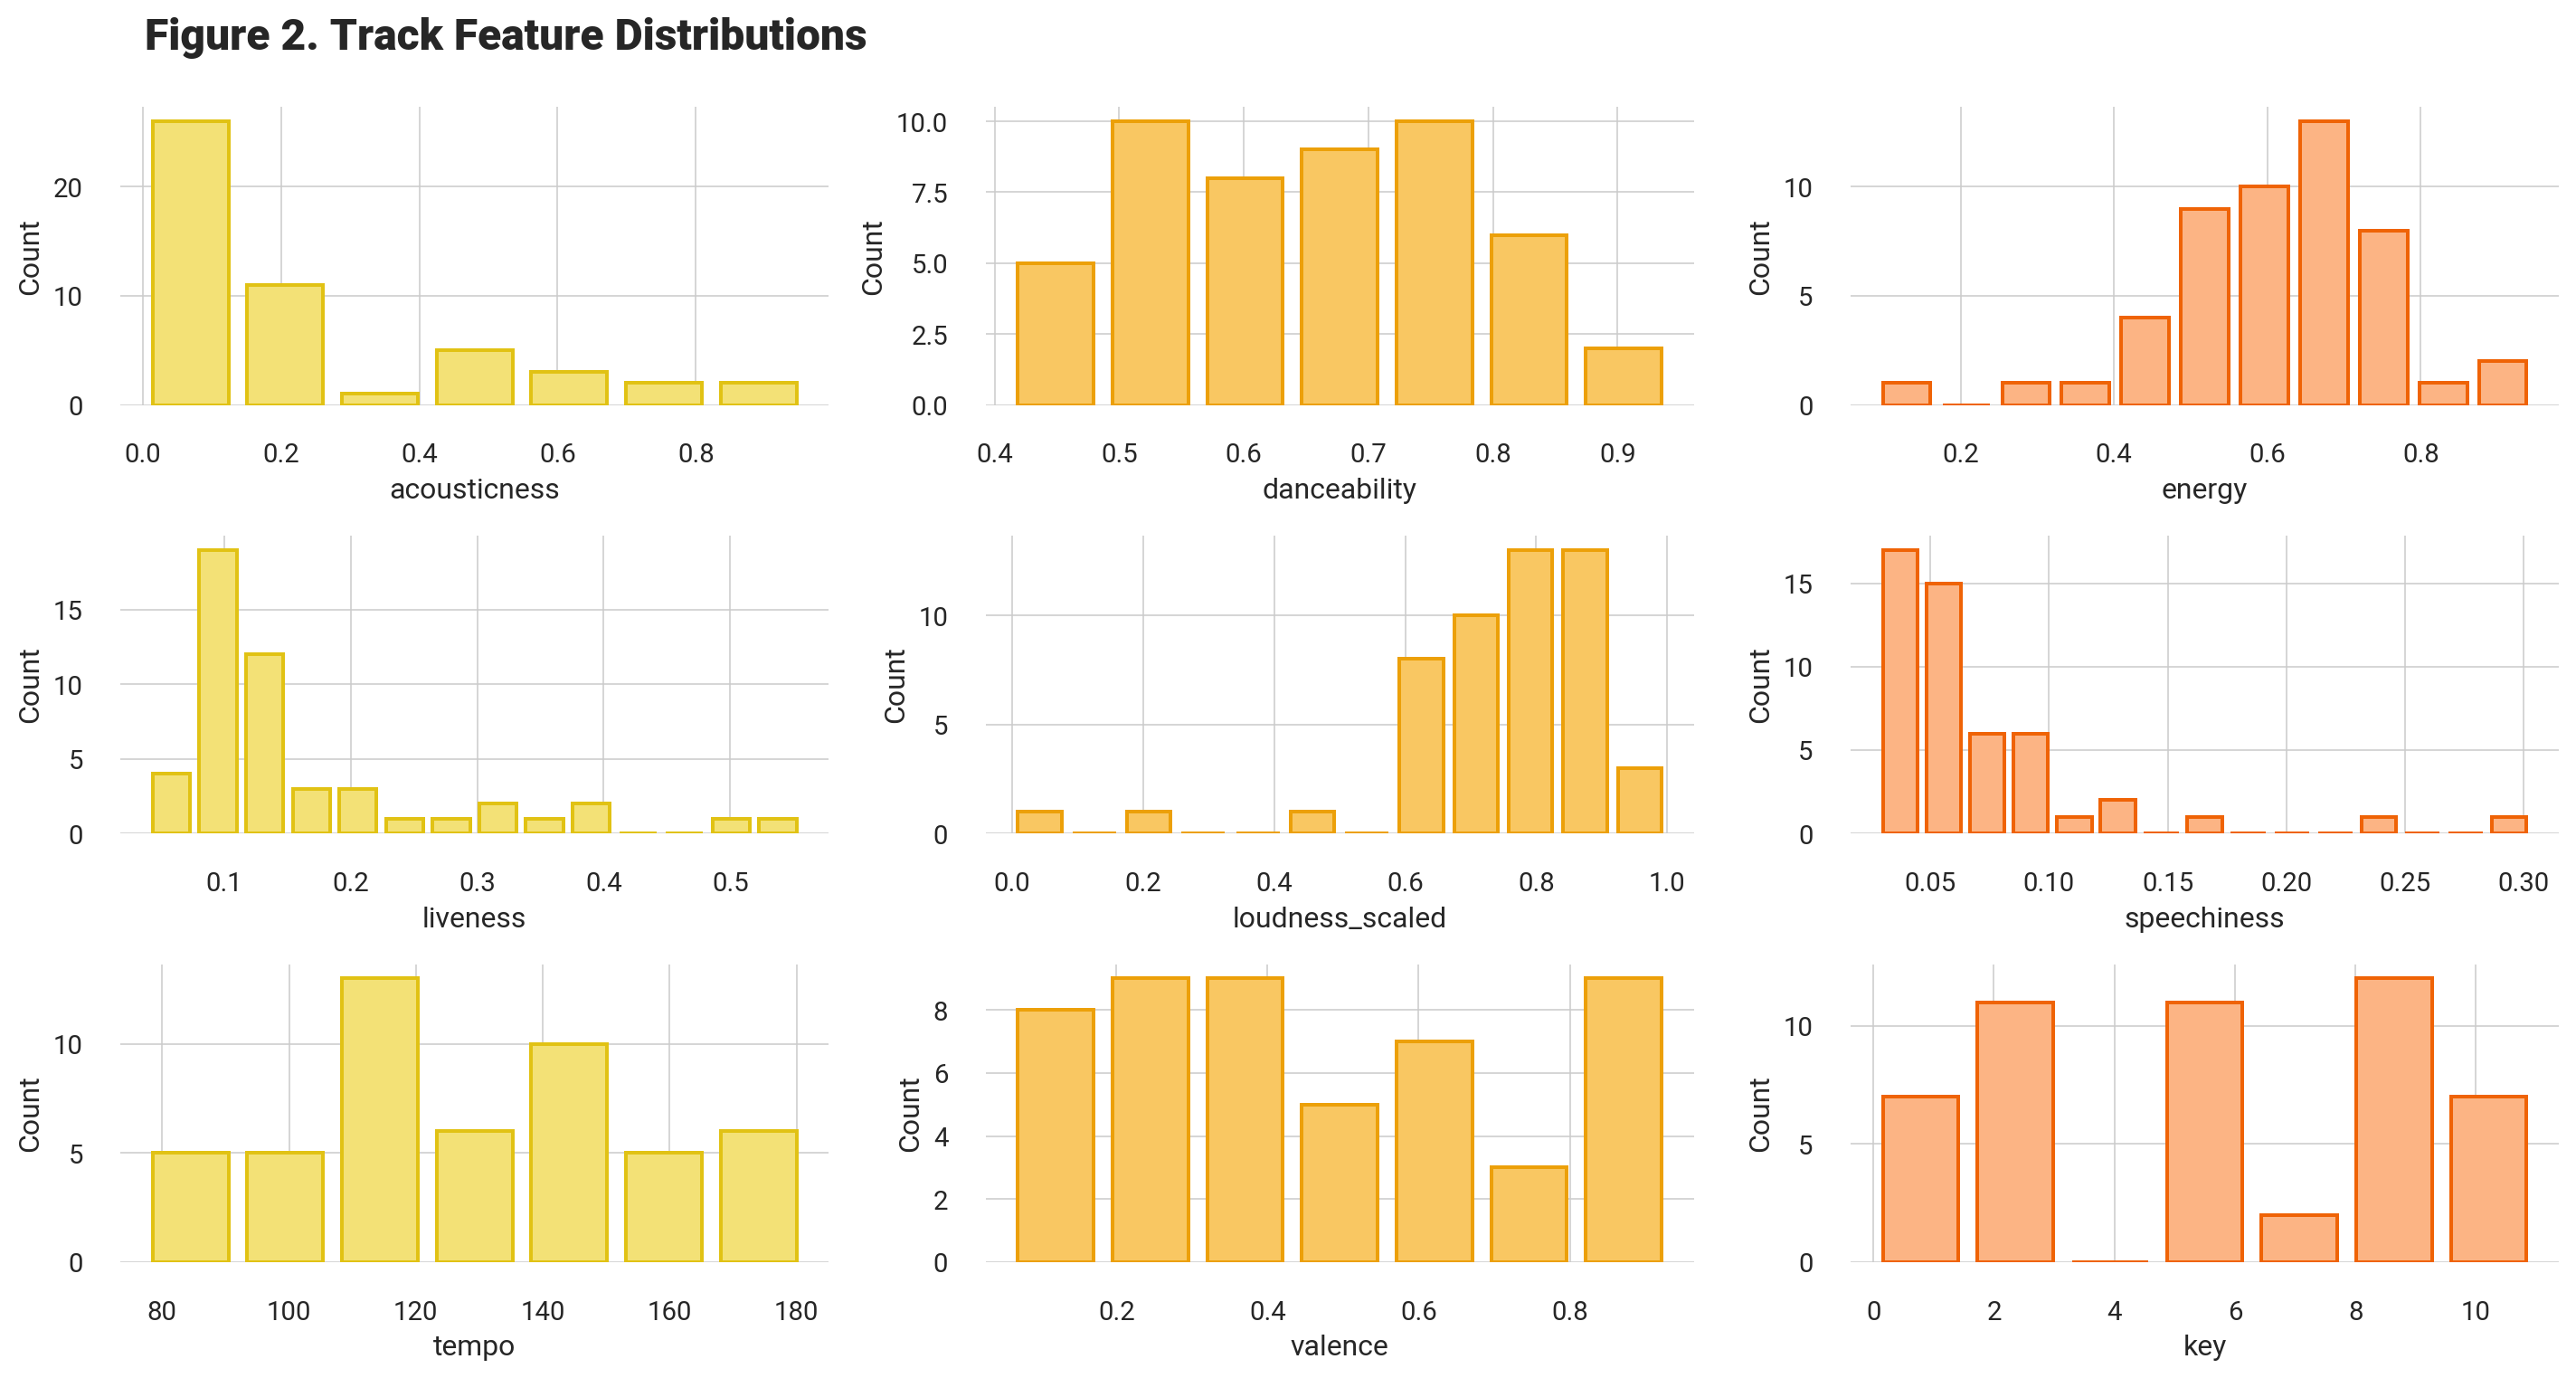

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8))
fig.suptitle("Figure 2. Track Feature Distributions", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=all_tracks, x=all_tracks[all_tracks["acousticness"].notnull()]["acousticness"], color="#F3E176", alpha=1.0, ax=axs[0,0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["danceability"].notnull()]["danceability"], color="#F9C762", alpha=1.0, ax=axs[0,1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["energy"].notnull()]["energy"], color="#FCB484", alpha=1.0, ax=axs[0,2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)

sns.histplot(data=all_tracks, x=all_tracks[all_tracks["liveness"].notnull()]["liveness"], color="#F3E176", alpha=1.0, ax=axs[1,0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["loudness_scaled"].notnull()]["loudness_scaled"], color="#F9C762", alpha=1.0, ax=axs[1,1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["speechiness"].notnull()]["speechiness"], color="#FCB484", alpha=1.0, ax=axs[1,2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)

sns.histplot(data=all_tracks, x=all_tracks[all_tracks["tempo"].notnull()]["tempo"], color="#F3E176", alpha=1.0, ax=axs[2,0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["valence"].notnull()]["valence"], color="#F9C762", alpha=1.0, ax=axs[2,1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["key"].notnull()]["key"], color="#FCB484", alpha=1.0, ax=axs[2,2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)


#axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("../assets/images/features_dist.png", format="png", dpi=1200)
plt.show()

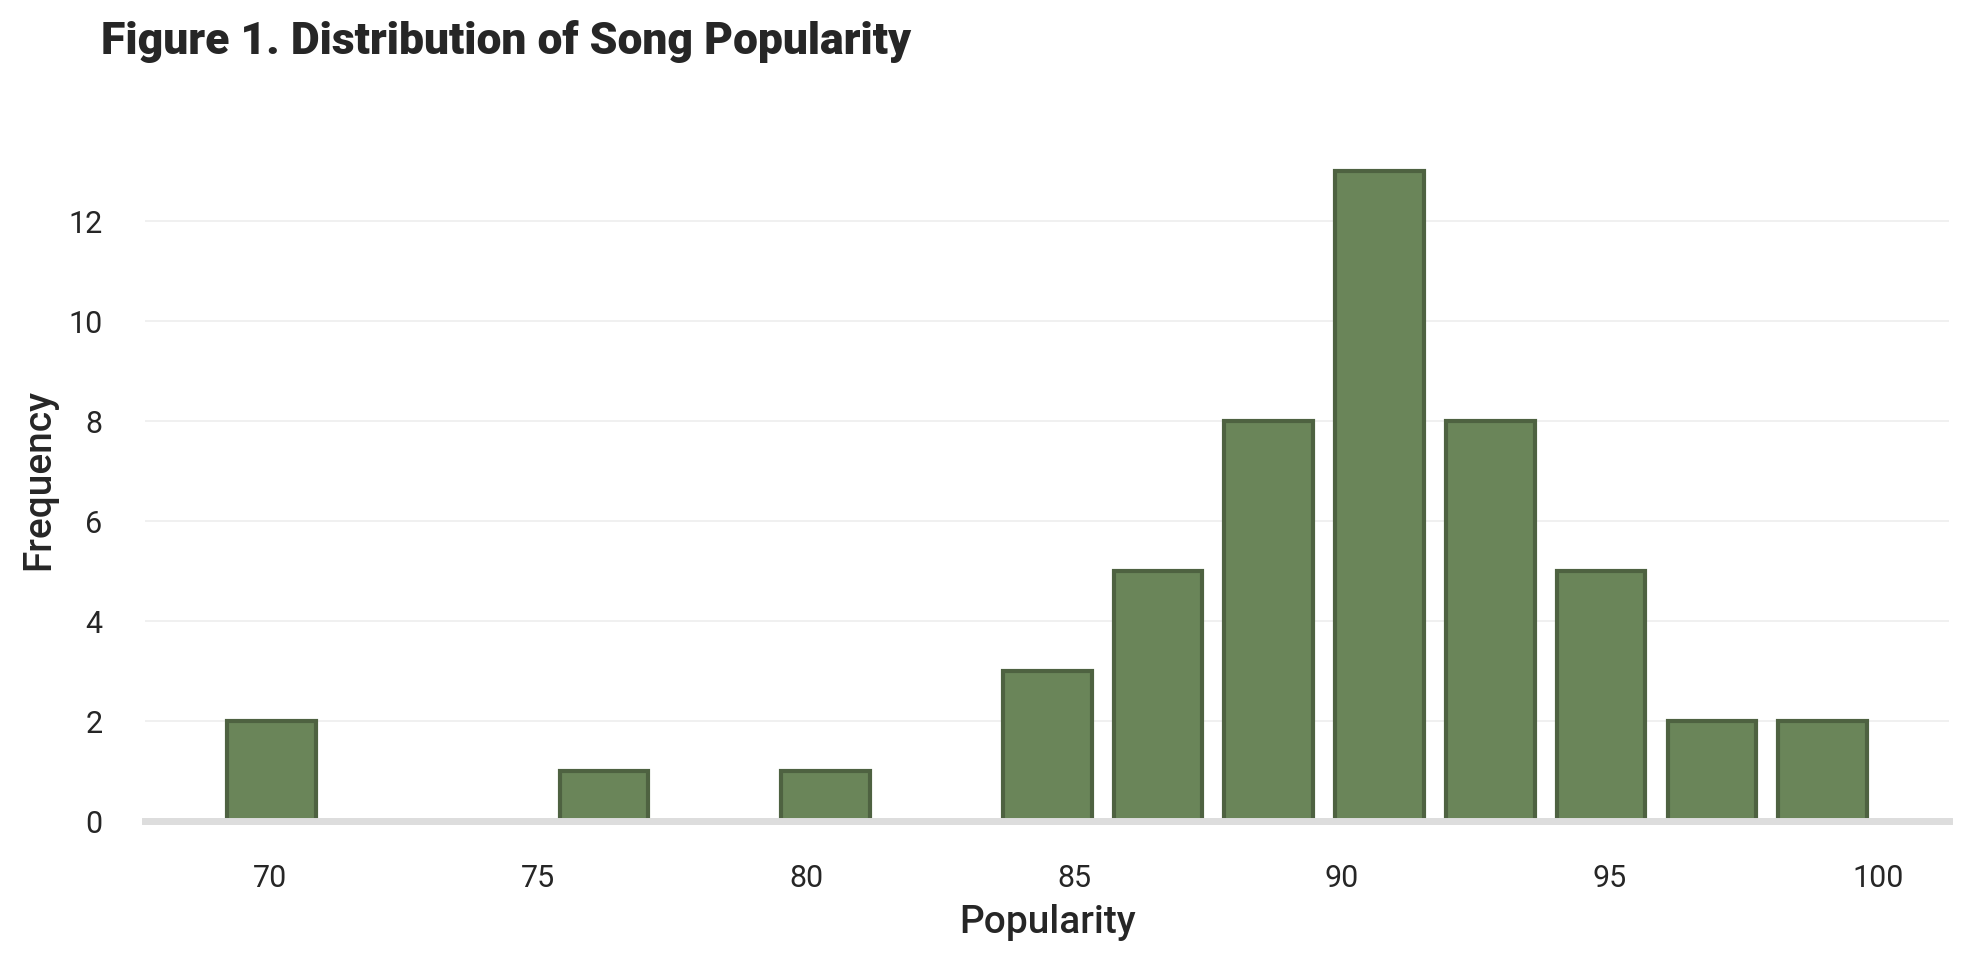

In [13]:
fig_hist = plt.figure(figsize = (10,5), dpi =100)
plt.title("Figure 1. Distribution of Song Popularity", weight='heavy',y =1.1, x=0.2).set_fontsize('16')
z = sns.histplot(data=all_tracks, x="popularity", color="#6A8559", alpha = 1.0, edgecolor="#4E6241", linewidth=1.5, shrink=.8)
sns.despine(left=True, bottom=False)
z.spines['bottom'].set_color('#DDDDDD')
z.yaxis.grid(True, color='#EEEEEE')
z.xaxis.grid(False)
plt.xlabel("Popularity", size=14, weight=500)
plt.ylabel("Frequency", size=14, weight=500)
plt.tight_layout()
plt.savefig("../assets/images/hold_times_dist.png", format="png", dpi=1200)
#plt.show()

### Twitter-roBERTa-base for Sentiment Analysis

Now, we present a graphical representation of the results obtained from the *roBERTa-base* model "trained on roughly 58 million tweets and fine-tuned for sentiment analysis using the TweetEval benchmark" (EMNLP 2020). According to the **TweetEval** reference paper and official Github repository, the resulting labels `0`, `1`, and `2` correspond to Negative, Neutral, and Positive, respectively.

- *Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive*

In [14]:
df_final = all_tracks_with_lyrics[['name', 'artist', 'release_date', 'length', 'popularity', 
         'artist_pop', 'artist_genres', 'acousticness', 'danceability', 'energy',
         'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
         'sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'LABEL_0',
         'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

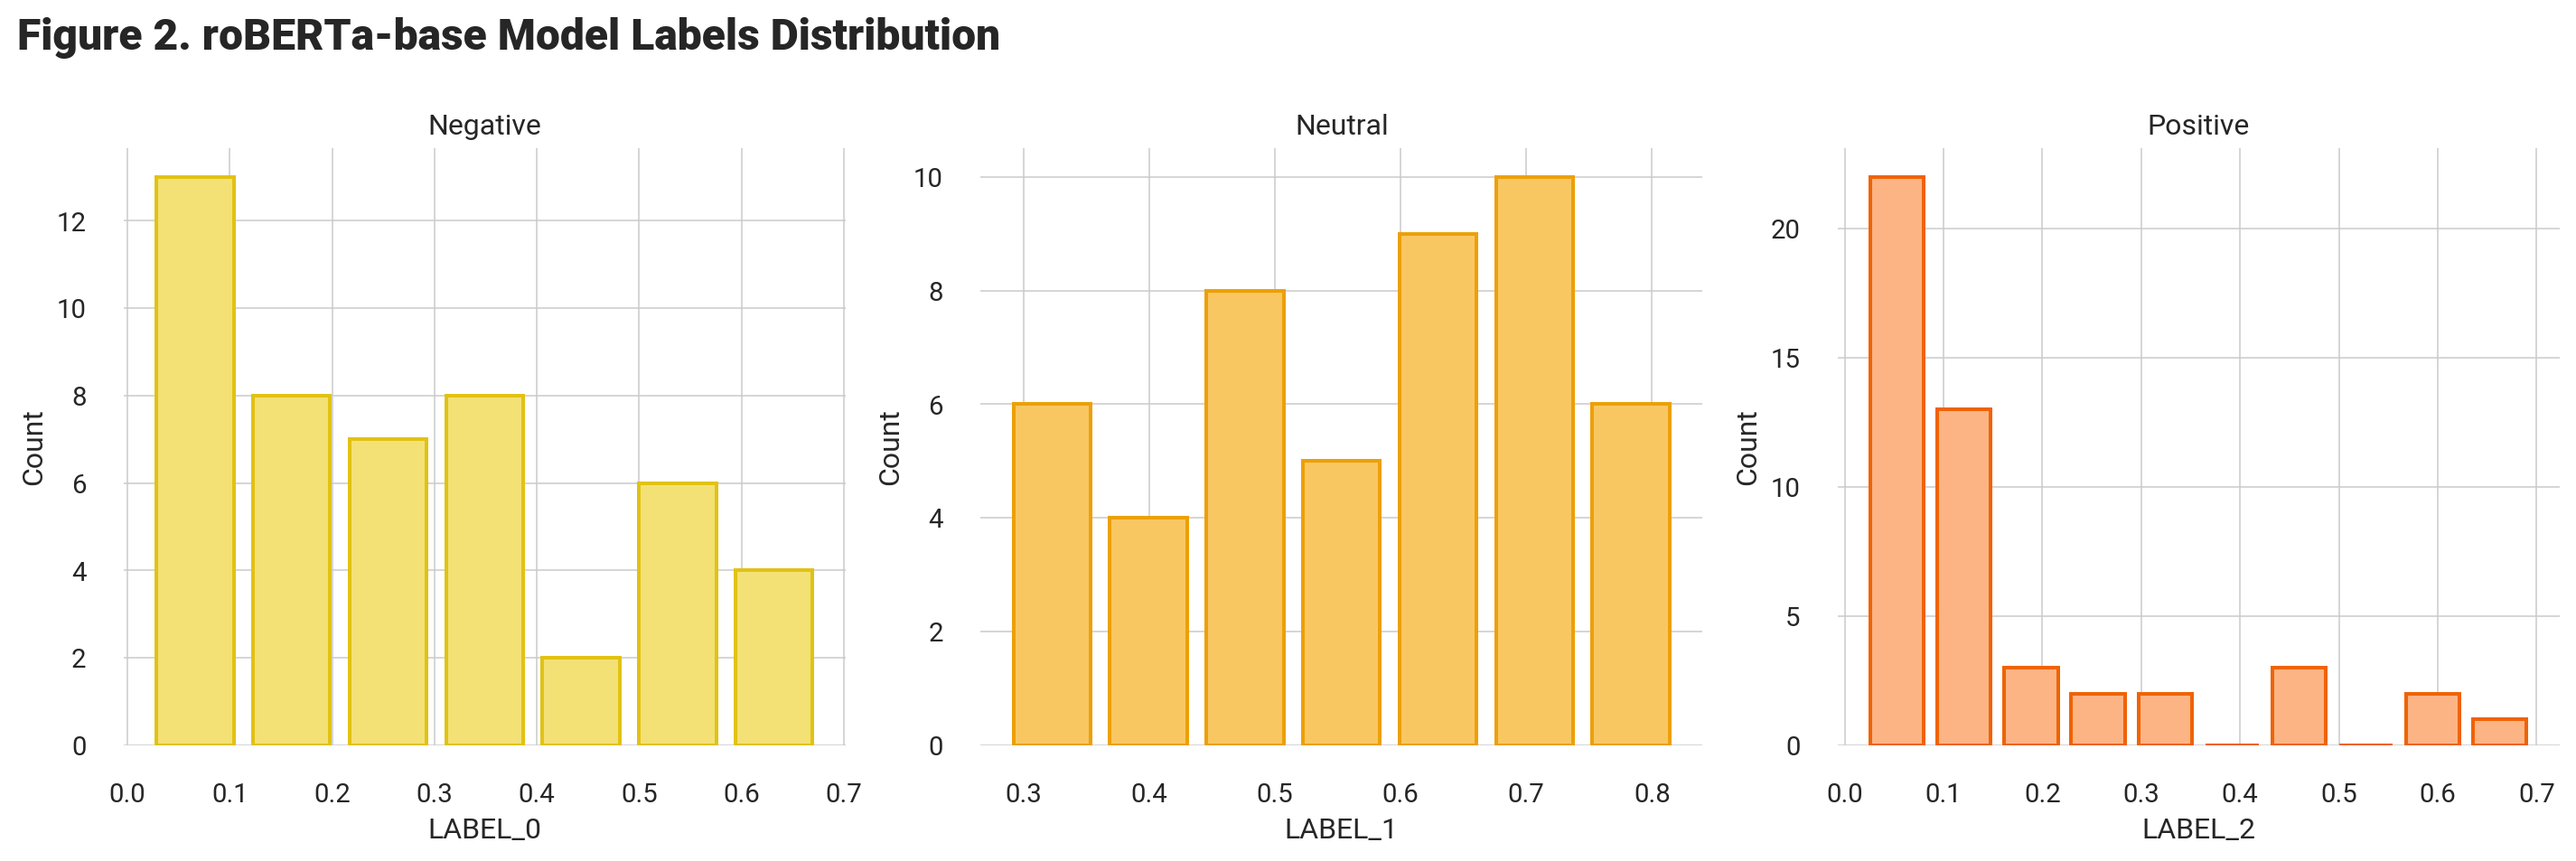

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 2. roBERTa-base Model Labels Distribution", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=df_final, x=df_final[df_final["LABEL_0"].notnull()]["LABEL_0"], color="#F3E176", alpha=1.0, ax=axs[0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
axs[0].set_title("Negative")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_1"].notnull()]["LABEL_1"], color="#F9C762", alpha=1.0, ax=axs[1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
axs[1].set_title("Neutral")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_2"].notnull()]["LABEL_2"], color="#FCB484", alpha=1.0, ax=axs[2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)
axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
fig.tight_layout()
plt.savefig("../assets/images/feat_dist.png", format="png", dpi=1200)
plt.show()

This code above creates a histogram that displays the distribution of labels for a roBERTa-base model. The labels are categorized as negative, neutral, or positive, with each having its own distinct color. Additionally, the code adds a title to the figure and resizes the subplots to ensure a better fit. The final output is a graph that can be saved in png format for future reference.

### Correlations Matrix

After completing the initial data analysis, we proceed with generating the Pearson correlations matrix using the Pandas command `df.corr()`. Subsequently, we visualize the matrix using the seaborn heatmap, providing a detailed understanding of the relationships between the various variables in our dataset.


In [16]:
track_sentiment_df = df_final[['name', 'artist',
           'acousticness', 'danceability', 'energy', 'instrumentalness', 
           'loudness', 'speechiness', 'tempo', 'valence', 
           'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
           'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

# Find the pearson correlations matrix
corr = track_sentiment_df.corr(method = 'pearson')

In [17]:
plt.figure(figsize=(10,8), dpi =650)
g = sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5, annot_kws={"size": 8}, cbar_kws={"shrink": .25})

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 9,family='Roboto')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 9,family='Roboto')
plt.title('Sentiment Analysis Model Labels Correlation Matrix')

#fig.tight_layout()
#plt.savefig("../assets/images/heatmap.png", format="png", dpi=1200)              
plt.show()

In [18]:
#fig, ax = plt.subplots(figsize=(10,6))
#sns.heatmap(corr, center=0, cmap='Blues')
#ax.set_title('Multi-Collinearity of Lyric NLP Sentiment Analysis')

The code below produces a scatterplot that showcases the correlation between energy and fear. The x-axis represents the energy value, while the y-axis represents the fear sentiment. The size of each data point corresponds to the label indicating the neutral sentiment level, and its color represents the valence value. Moreover, each bubble contains its energy value within, allowing for a straightforward interpretation of the data.


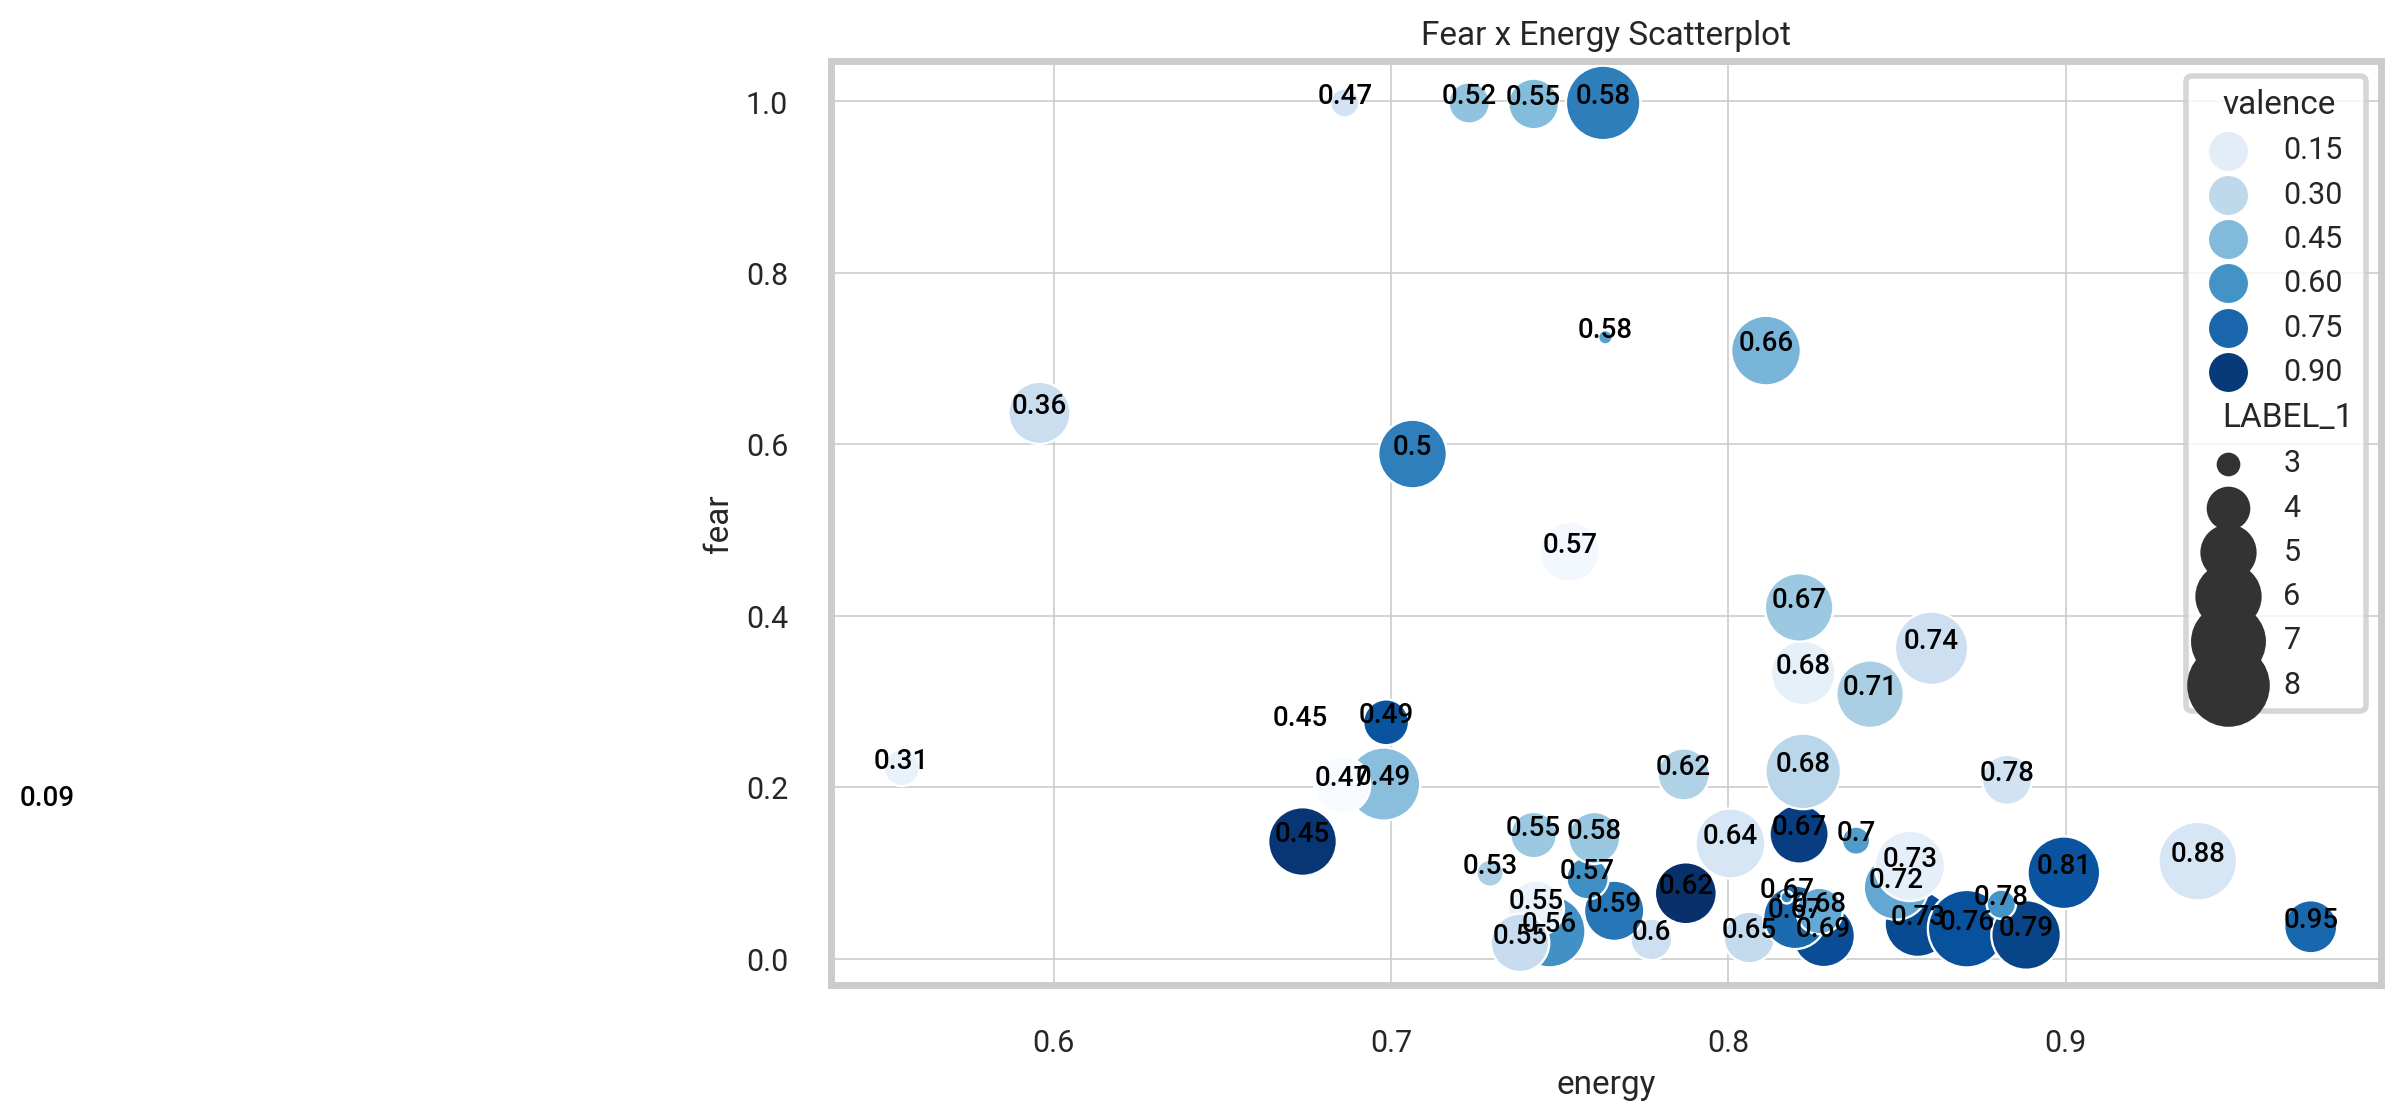

In [19]:
fig = plt.figure(figsize = (10,6), dpi=100)
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(x=track_sentiment_df['energy']**0.5, y=track_sentiment_df['fear']**0.5,
               size=track_sentiment_df['LABEL_1']*10, hue=track_sentiment_df['valence'],
               sizes=(20,800),
               palette='Blues')
#For each point, we add a text inside the bubble
for line in range(0,track_sentiment_df.shape[0]):
     ax.text(track_sentiment_df.energy[line]**0.5, track_sentiment_df.fear[line]**0.5, 
             round(track_sentiment_df.energy[line], 2), 
             horizontalalignment='center', size='small', color='black', weight='semibold')
        
plt.title('Fear x Energy Scatterplot')
plt.savefig("../assets/images/fearXenergy.png", format="png", dpi=1200)
plt.show()

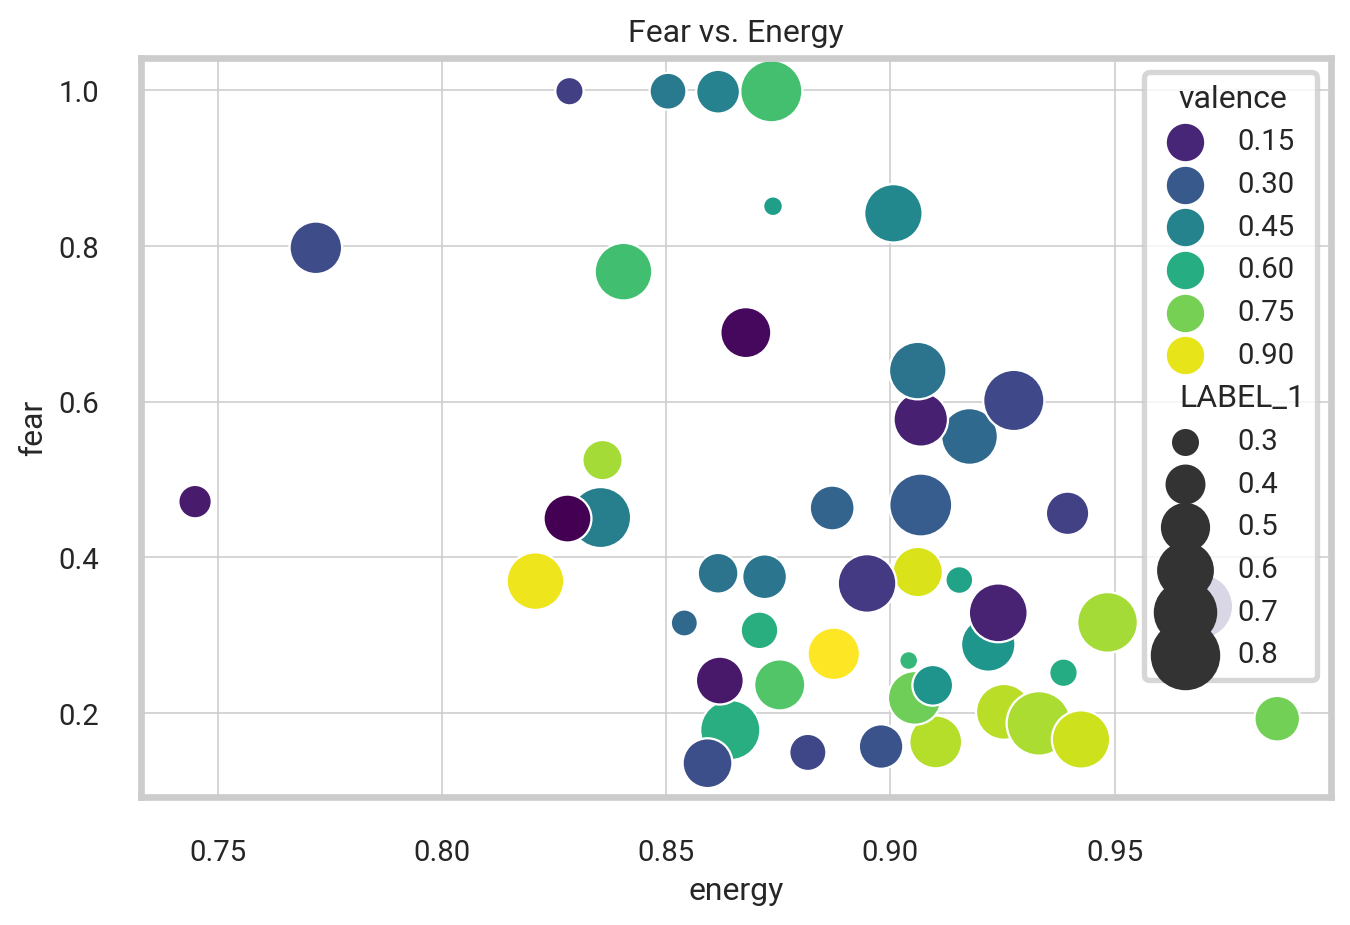

In [20]:
#fig = plt.figure(figsize = (10,6), dpi=800)
# Create scatterplot. alpha controls the opacity and s controls the size.
plot = sns.scatterplot(x = track_sentiment_df['energy']**0.25, 
                       y = track_sentiment_df['fear']**0.25,
                       hue = track_sentiment_df['valence'],
                       size = track_sentiment_df['LABEL_1'],
                       sizes = (50, 600),
                       size_order = track_sentiment_df['LABEL_1'],
                       palette = 'viridis')
plot.set_title('Fear vs. Energy')

plt.savefig("../assets/images/fearXenergy2.png", format="png", dpi=1200)

Similarly, the scatterplot presented above utilizes the track sentiment data, comparing the energy and fear levels of the tracks based on valence and size.